1. augmentation 제외
**augmentation의 영향을 알아보기 위해 실험 진행 (정확히는 데이터 비율도 바뀌었으므로 그런 요소도 고려해주어야 함**\
근데 사실 객관적이진 않음 ㅋㅋ 이건 age model을 age 기준으로 나누어진 데이터셋에서 학습함. 
=> augmentation 안하는게 더 좋았다..

2. augmentation 제외한 대신 weight 부여 (CrossEntropy) - 예정

# **1. Import module**

In [1]:
import os
import numpy as np
import pandas as pd
import albumentations
import albumentations.pytorch
import cv2
from PIL import Image
from glob import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize, CenterCrop, RandomCrop, RandomHorizontalFlip, RandomRotation

from sklearn.model_selection import train_test_split, StratifiedKFold

import matplotlib.pyplot as plt
import seaborn as sns

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device + ' is available.')

cuda is available.


# **2. Hyperparameters / Constant values**

In [2]:
# file path
train_dir = '/opt/ml/input/data/train/'
test_dir = '/opt/ml/input/data/eval/'
weight_dir = '/opt/ml/weight/'

# abnormal data
except_data = ['004432_male_Asian_43', '001498-1_male_Asian_23', 
               '006359_female_Asian_18', '006360_female_Asian_18', 
               '006361_female_Asian_18', '006362_female_Asian_18',
               '006363_female_Asian_18', '006364_female_Asian_18']

# hyperparameter
batch_size = 64
random_state = 444
cross_entropy_weight = torch.tensor([1 for x in range(18)]).float().to(device)

# image normalization
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
mean = [0.56019358, 0.52410121, 0.501457]
std = [0.23318603, 0.24300033, 0.24567522]

# **3. Data preprocessing/Dataloader(KFold)**

In [3]:
def age2label(age):
    if age < 30: return 0
    elif age < 58: return 1
    else: return 2
    

df = pd.read_csv(os.path.join(train_dir, 'train.csv'))
df = df[df['path'].apply(lambda x: x not in except_data)]

df.drop(['id', 'race'], axis=1, inplace=True)
df['path'] = train_dir + 'images/' + df['path']
df['age'] = df['age'].apply(age2label)
df['gender'] = df['gender'].apply(lambda x: 0 if x == 'male' else 1)
df = df[['age', 'path']]

print(df['age'].value_counts())
print(df.head())

cross_entropy_weight = torch.tensor(list(df['age'].value_counts())).float().to(device)
cross_entropy_weight

0    1274
1     982
2     436
Name: age, dtype: int64
   age                                               path
0    1  /opt/ml/input/data/train/images/000001_female_...
1    1  /opt/ml/input/data/train/images/000002_female_...
2    1  /opt/ml/input/data/train/images/000004_male_As...
3    2  /opt/ml/input/data/train/images/000005_female_...
4    2  /opt/ml/input/data/train/images/000006_female_...


tensor([1274.,  982.,  436.], device='cuda:0')

In [4]:
test_size=0.2

train_datas, test_datas, _, _ = train_test_split(df['path'], df['age'], test_size=test_size,
                                                   random_state=random_state, shuffle=True, stratify=df['age'])

train_path = []
for train_data in train_datas:
    train_path.extend(glob(train_data + '/*.*'))

test_path = []
for test_data in test_datas:
    test_path.extend(glob(test_data + '/*.*'))

len(train_path), len(test_path)

(15071, 3773)

In [5]:
class ImageDataset(Dataset):
    def __init__(self, img_list, label_list, transform=None):
        super(ImageDataset, self).__init__()
        self.img_list = img_list
        self.label_list = label_list
        self.transform = transform
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image = Image.open(self.img_list[idx])
        label = self.label_list[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label
    
    
def get_label_as_logit(img_paths, mode=1):
    # mode 0: 0-3/0-2/0-3
    # mode 1: 0-17
    
    label2logit = []
    for img_path in img_paths:
        path, file = os.path.split(img_path)
        gender, _, age = path.split('/')[7].split('_')[1:]
        mask = file[0]
        age = int(age)

        age_logit = 0
        gender_logit = 0
        mask_logit = 0

        if age < 30: age_logit=0
        elif age < 58: age_logit=1
        else: age_logit=2

        if gender == 'male': gender_logit=0
        else: gender_logit=1

        if mask=='m': mask_logit=0
        elif mask=='i': mask_logit=1
        else: mask_logit=2

        if mode == 0:
            label2logit.append([mask_logit, gender_logit, age_logit])
        else:
            label2logit.append(mask_logit * 6 + gender_logit * 3 + age_logit)

    return label2logit


train_label = get_label_as_logit(train_path)
test_label = get_label_as_logit(test_path)

len(train_label), len(test_label)
train_ls = pd.Series(train_label).value_counts()
test_ls = pd.Series(test_label).value_counts()
print(pd.concat([train_ls, test_ls, train_ls / test_ls], axis=1))

       0    1         2
0   2190  550  3.981818
1   1250  315  3.968254
2    730  165  4.424242
3   2905  725  4.006897
4   2675  670  3.992537
5   1015  270  3.759259
6    438  110  3.981818
7    250   63  3.968254
8    146   33  4.424242
9    581  145  4.006897
10   535  134  3.992537
11   203   54  3.759259
12   438  110  3.981818
13   250   63  3.968254
14   146   33  4.424242
15   581  145  4.006897
16   535  134  3.992537
17   203   54  3.759259


# **4. Data plot**

In [6]:
transform_train = transforms.Compose([
    CenterCrop((400,200)),
    ToTensor(),
])

transform_test = transforms.Compose([
    CenterCrop((400,200)),
    ToTensor(),
])

train_dataset = ImageDataset(img_list=train_path, label_list=train_label, transform=transform_train)
test_dataset = ImageDataset(img_list=test_path, label_list=test_label, transform=transform_test)

dataloaders = {'train': [DataLoader(train_dataset, batch_size=batch_size, shuffle=True)],
               'test': [DataLoader(test_dataset, batch_size=batch_size, shuffle=True)]}

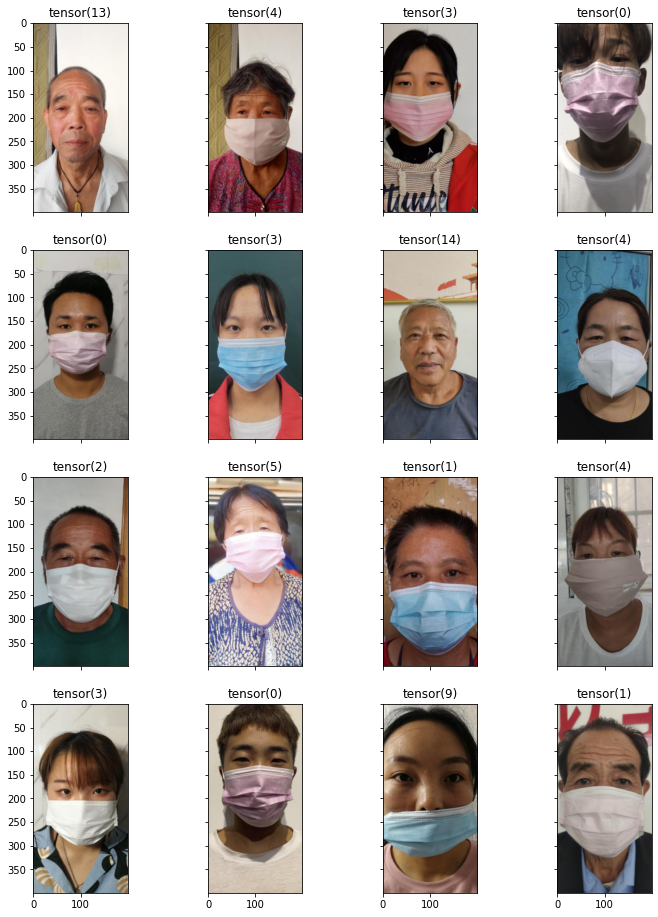

In [7]:
fig, axs = plt.subplots(figsize=(12, 16), nrows=4, ncols=4, sharex=True, sharey=True)

for X, y in dataloaders['train'][0]:
    for i, (X, y) in enumerate(zip(X[:16], y[:16])):
        axs[i % 4][i // 4].imshow(X.permute(1, 2, 0))
        axs[i % 4][i // 4].set_title(str(y))
    break
# plt.tight_layout()

# **5. Model setting**

In [8]:
from efficientnet_pytorch import EfficientNet

n_epoch = 5
learning_rate = 3e-4
weight_decay = 0.0
n_kfold = 1

mask_model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=3)
gender_model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=2)
age_model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=3)
models = [mask_model, gender_model, age_model]

Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0


# **7. Training**

In [9]:
import time
import copy
from tqdm import tqdm

def label2proper(mtype, label):
    if mtype == 0:
        label = label // 6
    elif mtype == 1:
        label = label % 6 // 3
    else:
        label = label % 3
    return label
        
def train(mtype, model, criterion, optimizer, n_epoch, dataloaders, scheduler=None, n_kfold=1):
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    since = time.time()

    for i in range(n_kfold):
        print("-" * 10)
        print(f"{i + 1} FOLD START")

        for epoch in range(n_epoch):
            print(f"[Epoch {epoch}/{n_epoch - 1}]")
            print('-' * 10)

            # epoch 1개마다 저장할거 아니면 이부분 수정
            phase_set = ['train'] if epoch % 1 != 0 else ['train', 'test']
            for phase in phase_set:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in tqdm(dataloaders[phase][i]):
                    inputs = inputs.to(device)
                    labels = label2proper(mtype, labels).to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if scheduler and phase == 'train':
                    scheduler.step(running_loss)

                epoch_loss = running_loss / len(dataloaders[phase][i].dataset)
                epoch_acc = 100. * running_corrects.double() / len(dataloaders[phase][i].dataset)

                print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_weights = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
        print(f"Best val Acc: {best_acc:.4f}")
        print('\n')

        print(f"{i + 1} FOLD END")
        print("-" * 10)
        
        return best_model_weights

criterion = nn.CrossEntropyLoss(weight=cross_entropy_weight)
# Age model만 재학습. (augmentation 없이)

age_model = age_model.to(device)
optimizer = torch.optim.Adam(age_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5)
best_model_weights = train(mtype=2, model=age_model, criterion=criterion, 
                           optimizer=optimizer, n_epoch=10, dataloaders=dataloaders, scheduler=scheduler)
age_model.load_state_dict(best_model_weights)

  0%|          | 0/236 [00:00<?, ?it/s]

----------
1 FOLD START
[Epoch 0/9]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.2288 Acc: 86.3778


  0%|          | 0/236 [00:00<?, ?it/s]

test Loss: 0.4812 Acc: 78.9557
[Epoch 1/9]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0661 Acc: 96.2245


  0%|          | 0/236 [00:00<?, ?it/s]

test Loss: 0.3450 Acc: 85.5818
[Epoch 2/9]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0323 Acc: 98.3080


  0%|          | 0/236 [00:00<?, ?it/s]

test Loss: 0.3809 Acc: 85.7408
[Epoch 3/9]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0207 Acc: 98.9782


  0%|          | 0/236 [00:00<?, ?it/s]

test Loss: 0.4091 Acc: 86.6684
[Epoch 4/9]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0185 Acc: 99.1640


  0%|          | 0/236 [00:00<?, ?it/s]

test Loss: 0.4514 Acc: 86.6154
[Epoch 5/9]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0125 Acc: 99.3896


  0%|          | 0/236 [00:00<?, ?it/s]

test Loss: 0.4822 Acc: 86.8010
[Epoch 6/9]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0076 Acc: 99.6284


  0%|          | 0/236 [00:00<?, ?it/s]

test Loss: 0.5630 Acc: 85.3432
[Epoch 7/9]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0108 Acc: 99.4957


  0%|          | 0/236 [00:00<?, ?it/s]

test Loss: 0.6750 Acc: 84.9457
[Epoch 8/9]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0144 Acc: 99.3099


  0%|          | 0/236 [00:00<?, ?it/s]

test Loss: 0.5936 Acc: 84.2301
[Epoch 9/9]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0143 Acc: 99.2967


100%|██████████| 59/59 [00:21<00:00,  2.71it/s]

test Loss: 0.5947 Acc: 85.9263
Training complete in 26m 41s
Best val Acc: 86.8010


1 FOLD END
----------


<All keys matched successfully>

In [15]:
mask_model = mask_model.to(device)
gender_model = gender_model.to(device)

torch.save(age_model.state_dict(), weight_dir + 'efficient_v12-age.pth')
mask_model.load_state_dict(torch.load(weight_dir + 'efficient_v11-mask.pth'))
gender_model.load_state_dict(torch.load(weight_dir + 'efficient_v11-gender.pth'))

<All keys matched successfully>

# **8. Inference**

In [16]:
class TestDataset(Dataset):
    def __init__(self, root_dir, transform):
        super(TestDataset, self).__init__()
        self.root_dir = root_dir
        self.transform = transform
        self.img_list = sorted(glob(os.path.join(root_dir, 'images/*.*')))
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image = Image.open(self.img_list[idx])
        
        if self.transform:
            image = self.transform(image)
            
        return image

In [17]:
submission = pd.read_csv(test_dir + 'info.csv')
submission.sort_values(by='ImageID', inplace=True)

test_dataset = TestDataset(root_dir=test_dir, transform=transform_test)
test_dataloader = DataLoader(test_dataset, shuffle=False, num_workers=4)

all_predictions = []

mask_model.eval()
gender_model.eval()
age_model.eval()
for images in tqdm(test_dataloader):
    with torch.no_grad():
        images = images.float().to(device)
        preds = []
        for model in models:
            output = model(images)
            _, predicted = torch.max(output, 1)
            preds.append(predicted.cpu().numpy())
        pred_logit = preds[0] * 6 + preds[1] * 3 + preds[2]
        all_predictions.append(pred_logit)

100%|██████████| 12600/12600 [08:06<00:00, 25.91it/s]


In [18]:
all_predictions = [x[0] for x in all_predictions]

In [19]:
submission['ans'] = all_predictions
submission.head()

,ImageID,ans
7220,0001b62fb1057a1182db2c839de232dbef0d1e90.jpg,3
6246,0007a12486cabfd419323a5eb75bcbb7fcd3e394.jpg,12
4183,0007d32b13ba3ee17f1c9aaf0f4df70599d04e8f.jpg,2
733,0015ff2242eb049f9242db967f4530a701d3d4f7.jpg,0
5500,0016162a11c94b63dc4c96c3923efed1f54fe57c.jpg,2


In [20]:
submission.sort_index(inplace=True)
submission.head()

,ImageID,ans
0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,14
1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,2
2,b549040c49190cedc41327748aeb197c1670f14d.jpg,14
3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,14
4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,12


# **9. Checking/Submit**

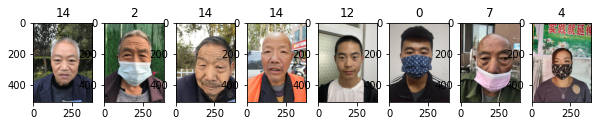

In [21]:
fig, axs = plt.subplots(figsize=(10, 50), nrows=1, ncols=8)

for i in range(8):
    label = submission.iloc[i, 1]
    img_name = submission.iloc[i, 0]
    img_name = os.path.join(test_dir, 'images/', img_name)
    image = Image.open(img_name)
    
    axs[i].set_title(label)
    axs[i].imshow(image)
    
plt.show()

In [22]:
submission.to_csv(os.path.join(test_dir, '/opt/ml/submission/submission_v12.csv'), index=False)
print('test inference is done.')

test inference is done.
